In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_clean = pd.read_csv('cleaning_data.csv')
data_clean.head()

,Suburb,Suburb_Code,Land Size SQM,Building Size SQM,Bedrooms,Toilets,Car,School,Shop,Restaurant,Station,Park,Hospital,Rent Amount PW,Auction,Last Sell Date,Last Sell Price,Sell Date,Sell Price
0,Armstrong Creek,1,539.0,176.000000,4.0,2.0,2.0,4,17,6,17,4,0,390.000000,0.0,2000-02-01,175000.0,2021-03-01,610000
1,Armstrong Creek,1,446.0,157.800253,4.0,2.0,2.0,5,9,7,14,3,0,800.847867,0.0,2019-04-01,545000.0,2021-03-01,645000
2,Armstrong Creek,1,398.0,161.000000,4.0,2.0,2.0,2,3,4,14,4,0,400.000000,0.0,2018-10-01,550000.0,2021-03-01,597500
3,Armstrong Creek,1,630.0,157.800253,4.0,2.0,4.0,2,4,4,14,3,0,800.847867,0.0,2014-03-01,207000.0,2021-03-01,841000
4,Armstrong Creek,1,449.0,170.000000,4.0,2.0,2.0,1,2,4,12,3,0,800.847867,0.0,2017-07-01,475000.0,2021-03-01,640000


In [3]:
data_clean.describe(include=['object'])

,Suburb,Last Sell Date,Sell Date
count,10943,10943,10943
unique,31,436,448
top,St Albans Park,2000-02-01,2019-12-01
freq,741,245,434


In [4]:
data = data_clean[['Sell Date','Sell Price']]
data

,Sell Date,Sell Price
0,2021-03-01,610000
1,2021-03-01,645000
2,2021-03-01,597500
3,2021-03-01,841000
4,2021-03-01,640000
...,...,...
10938,2016-07-01,600000
10939,2016-07-01,375000
10940,2016-06-01,300000
10941,2016-06-01,255000


<AxesSubplot:xlabel='Sell Date'>

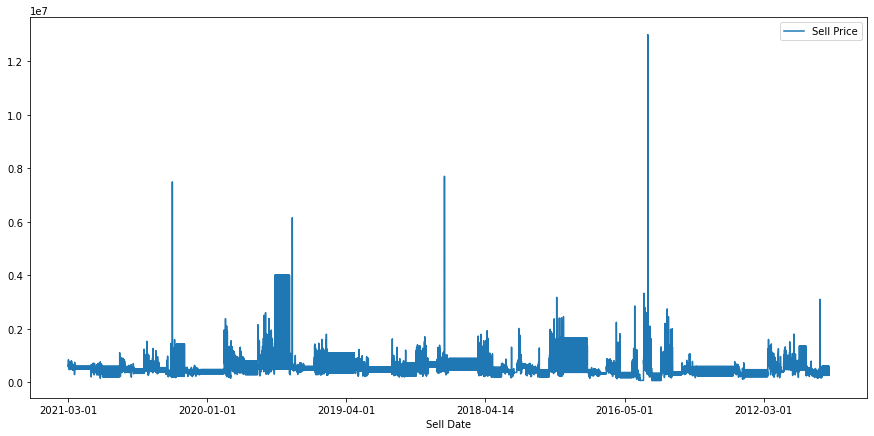

In [5]:
data.set_index('Sell Date',inplace=True)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
data.plot()

In [7]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(data['Sell Price'])
test_result

(-5.815265337361061,
 4.307230902868894e-07,
 39,
 10903,
 {'1%': -3.430949911973261,
  '5%': -2.8618051278244807,
  '10%': -2.5669111224099344},
 304614.51397520734)

In [11]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )


In [12]:
# if result[1] <= 0.05:
#     print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
# else:
#     print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(data['Sell Price'])

ADF Test Statistic : -5.815265337361061
p-value : 4.307230902868894e-07
#Lags Used : 39
Number of Observations : 10903


In [15]:
data['Sell price First Difference'] = data['Sell Price'] - data['Sell Price'].shift(1)
data['Seasonal First Difference']=data['Sell Price']-data['Sell Price'].shift(12)
data.head()

,Sell Price,Sell price First Difference,Seasonal First Difference
Sell Date,,,
2021-03-01,610000,NaN,NaN
2021-03-01,645000,35000.0,NaN
2021-03-01,597500,-47500.0,NaN
2021-03-01,841000,243500.0,NaN
2021-03-01,640000,-201000.0,NaN


In [16]:
# Again testing if data is stationary
adfuller_test(data['Seasonal First Difference'].dropna())

ADF Test Statistic : -21.09621088354822
p-value : 0.0
#Lags Used : 39
Number of Observations : 10891


<AxesSubplot:xlabel='Sell Date'>

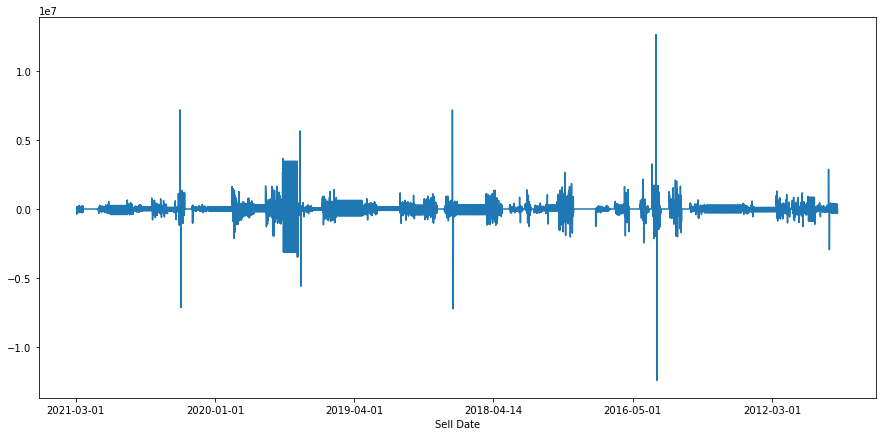

In [17]:
data['Seasonal First Difference'].plot()

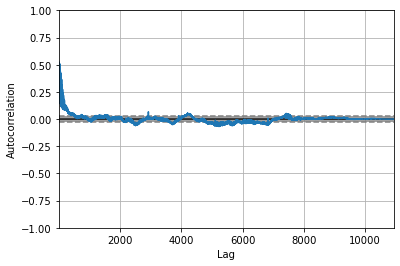

In [20]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['Sell Price'])
plt.show()

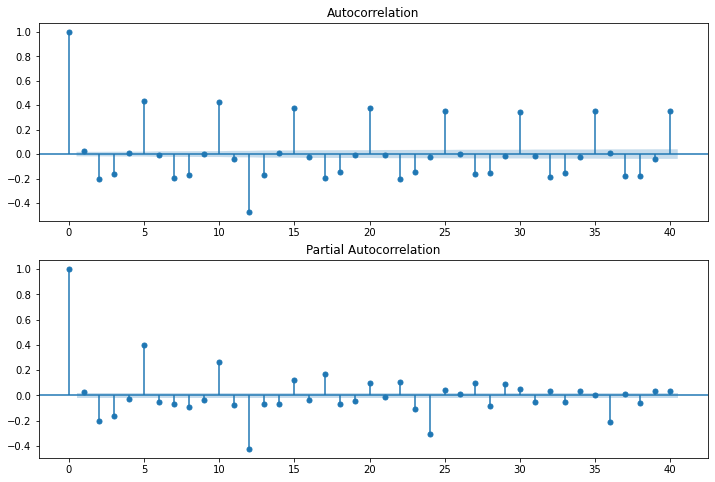

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

In [22]:
# For non-seasonal data
#p=1, d=1, q=0 or 1

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(data['Sell Price'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Sell Price   No. Observations:                10942
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -154731.301
Method:                       css-mle   S.D. of innovations         335037.509
Date:                Sat, 24 Apr 2021   AIC                         309470.601
Time:                        21:14:32   BIC                         309499.803
Sample:                             1   HQIC                        309480.442
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -31.9868    171.442     -0.187      0.852    -368.006     304.033
ar.L1.D.Sell Price    -0.0911      0.010     -9.170      0.000      -0.111      -0.072
ma.L1.D.Sell Price    -0.9417      0.003   -302.027      0.000      -0.948      -0.936
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -10.9753           +0.0000j           10.9753            0.5000
MA.1            1.0619           +0.0000j            1.0619            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
data.reset_index(inplace=True)

In [45]:
predict=pd.Series(model_fit.predict(start=90,end=103,dynamic=True))
data = predict.to_frame().combine_first(data)
data

,0,Predict,Seasonal First Difference,Sell Date,Sell Price,Sell price First Difference
0,NaN,NaN,NaN,2021-03-01,610000.0,NaN
1,NaN,NaN,NaN,2021-03-01,645000.0,35000.0
2,NaN,NaN,NaN,2021-03-01,597500.0,-47500.0
3,NaN,NaN,NaN,2021-03-01,841000.0,243500.0
4,NaN,NaN,NaN,2021-03-01,640000.0,-201000.0
...,...,...,...,...,...,...
2020-06-01,-32.137895,-32.137895,NaN,NaN,NaN,NaN
2020-06-01,-32.137895,-32.137895,NaN,NaN,NaN,NaN
2020-06-01,-32.137895,-32.137895,NaN,NaN,NaN,NaN
2020-06-01,-32.137895,-32.137895,NaN,NaN,NaN,NaN


<AxesSubplot:>

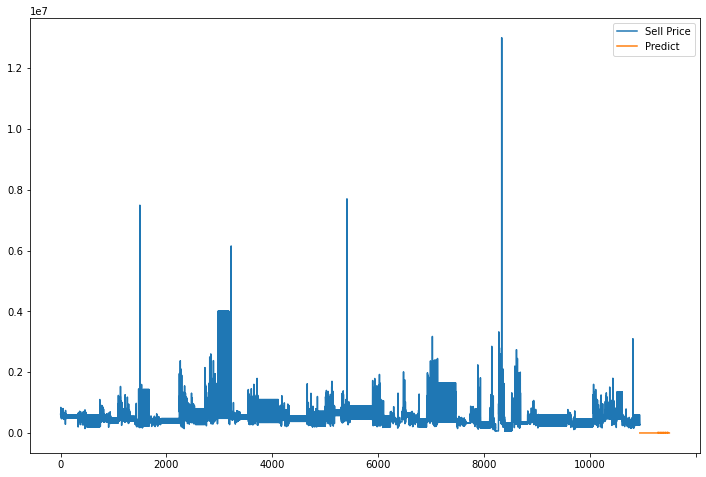

In [47]:
data[['Sell Price','Predict']].plot(figsize=(12,8))

<AxesSubplot:>

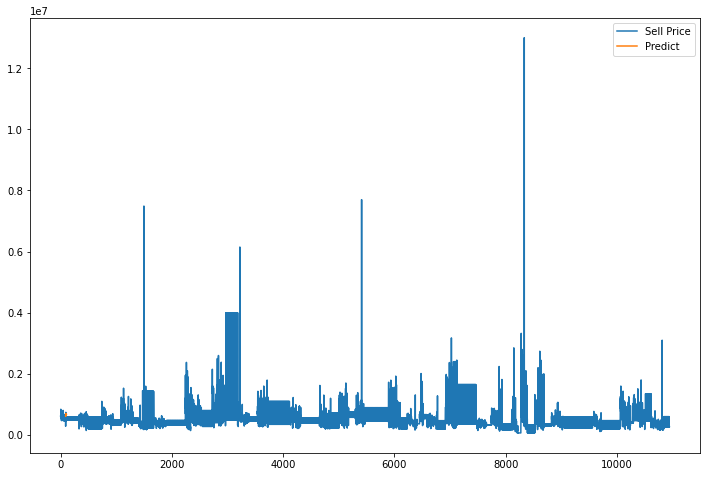

In [48]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(data['Sell Price'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
data['Predict']=results.predict(start=90,end=103,dynamic=True)
data[['Sell Price','Predict']].plot(figsize=(12,8))